# Machine Learning in Computational Biology
## Course Project
## 11 class problem classification - Pipeline/ Results Notebook
#### Vossos Charalampos, ID:7115152200037
#### Fillipidou Thalassini-Marina, ID:7115152200022
#### Papadopoulou Marianna, ID:7115152200032

This notebook presents all the pipeline for the 2class classification problem
of cells based on their gene profile. It contains all the optimization steps, hyperparameter tunning and the feature selection techniques that were tested
In order to replicate the findings outlined in this academic document, please follow the steps below:

1.	Open the notebook provided using Google Colab
2.	Access the data section of the environment by clicking on the folder icon located on the left side.
Then, upload the:
  - final_data.csv file

 The file is available within the exercise's zip file. To upload them, simply drag and drop the files into the designated area.

3. Run the cells in the notebook in the order they appear, making sure to follow the instructions provided in each cell.

When executing the notebook in Jupyter, it is essential to ensure that the necessary packages have been installed. Additionally, it is important to specify the path to the dataset (final_data.csv or other three files) as an input parameter for the *pd.read_csv()* function.

# Libraries

In [ ]:
# Execute if opened with colab
#!pip install optuna
#!pip install mrmr

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import make_scorer, matthews_corrcoef, balanced_accuracy_score, f1_score, fbeta_score, recall_score, precision_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
import optuna
from optuna.samplers import RandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import random
from mrmr import mrmr_classif
from sklearn.preprocessing import LabelEncoder

c:\Users\maria\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load Dataset
In this notebook we do not present again the whole preprocessing steps and we load our data from the final_df.csv file obtained from the preprocessing steps in either of the notebooks of 2 and 4 class classification

In [ ]:
df_filtered = pd.read_csv('contentfinal_df.csv')

In [ ]:
# Separate features and target variable
X = df_filtered.iloc[:,1:-9]
y_labels = df_filtered.iloc[:,-9:]


In [ ]:
# Print the shape of the variable X (input data).
print(X.shape)

# Print the column names of the DataFrame 'y_labels', which presumably contains the target labels.
print(y_labels.columns.values)

# Extract the values from the column with index 4 in the 'y_labels' DataFrame.
# Convert the values to a string data type and store them in variable y.
y = y_labels[y_labels.columns.values[4]].values.astype(str)


# Create an instance of LabelEncoder and use it to encode the labels in y.
# This will convert the labels from string format to numerical format.
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Extract the number of classes from the column name in the DataFrame 'y_labels'.
# The column name seems to follow a pattern: 'column_name_numClasses'.
# Split the column name by "_" and extract the last part, which should represent the number of classes.
num_classes = int(y_labels.columns.values[4].split(("_"))[1])

# Print the number of classes.
print(num_classes)


(1427, 1500)
['cluster_2' 'cluster_4' 'cluster_7' 'cluster_8' 'cluster_11' 'cluster_18'
 'cluster_23' 'cluster_31' 'cluster_37']
11


In [ ]:
# Standardize the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_std, y, test_size=0.2, random_state=42)

# ANOVA for feature selection

## SVC



#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

Support Vector Macines


In [ ]:
# Define the objective function for Optuna hyperparameter tuning
def objective_SVC(trial):
  global best_features
  # Define the hyperparameters to be optimized
  C = trial.suggest_float('C', 0.1, 10)
  gamma = trial.suggest_float('gamma', 0.01, 1)
  kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
  degree = trial.suggest_int('degree', 2, 10)
  # Instantiate the classifier with the current hyperparameters
  classifier = SVC(C=C, gamma=gamma,kernel=kernel,degree=degree)

  # Perform cross-validation with feature selection
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []
  feature_selector = SelectKBest(score_func=f_classif, k=300)  # Adjust the number of features as desired
  best_features = None

  for train_index, val_index in kf.split(X_train_val, y_train_val):
      X_train, X_val = X_train_val[train_index], X_train_val[val_index]
      y_train, y_val = y_train_val[train_index], y_train_val[val_index]

      # Perform feature selection on the training set
      X_train_selected = feature_selector.fit_transform(X_train, y_train)
      selected_features = feature_selector.get_support()

      # Apply the same feature selection on the validation set
      X_val_selected = X_val[:, selected_features]

      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train_selected, y_train)
      y_pred = classifier.predict(X_val_selected)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)

  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  if trial.should_prune()==False:
    best_features = selected_features.copy()

  return avg_mcc

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='maximize',sampler=RandomSampler(seed=42))
study.optimize(objective_SVC, n_trials=100)

[I 2023-07-02 16:50:55,308] A new study created in memory with name: no-name-5df18b5c-d43b-4ab0-af41-0675acae0e69
[I 2023-07-02 16:50:56,988] Trial 0 finished with value: 0.7121020277694982 and parameters: {'C': 3.807947176588889, 'gamma': 0.951207163345817, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.7121020277694982.
[I 2023-07-02 16:50:59,629] Trial 1 finished with value: 0.0 and parameters: {'C': 8.675143843171858, 'gamma': 0.6051038616257767, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.7121020277694982.
[I 2023-07-02 16:51:01,344] Trial 2 finished with value: 0.2714476235104769 and parameters: {'C': 1.9000671753502962, 'gamma': 0.1915704647548995, 'kernel': 'poly', 'degree': 7}. Best is trial 0 with value: 0.7121020277694982.
[I 2023-07-02 16:51:03,450] Trial 3 finished with value: 0.0 and parameters: {'C': 1.4809892204552142, 'gamma': 0.29922320204986597, 'kernel': 'rbf', 'degree': 6}. Best is trial 0 with value: 0.7121020277694982.
[I 2023-07

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'C': 3.807947176588889,
 'gamma': 0.951207163345817,
 'kernel': 'linear',
 'degree': 2}

#### Get best parameters and make predictions

In [ ]:
selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features_indices]

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features_indices]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
best_classifier_SVC = SVC(C= 3.807947176588889,gamma= 0.951207163345817,kernel= 'linear',degree= 2)

In [ ]:
best_classifier_SVC.fit(X_train_val_selected_final_features, y_train_val)

SVC(C=3.807947176588889, degree=2, gamma=0.951207163345817, kernel='linear')

In [ ]:
y_test_pred = best_classifier_SVC.predict(X_test_selected)

In [ ]:
balanced_acc_SVC = balanced_accuracy_score(y_test, y_test_pred)
recall_SVC = recall_score(y_test, y_test_pred, average='weighted')
f1_SVC = f1_score(y_test, y_test_pred, average='weighted')
precision_SVC = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Support Vector Machines\n")
print("Accuracy:", balanced_acc_SVC)
print("F1 Score:", f1_SVC)
print("Precision:", precision_SVC)
print("Recall:", recall_SVC)

Support Vector Machines

Accuracy: 0.7587412587412588
F1 Score: 0.7569953910318524
Precision: 0.767091877238814
Recall: 0.7587412587412588


In [ ]:
# Get the coefficients of the best SVM classifier
coefs = best_classifier_SVC.coef_

# Calculate the absolute values of the coefficients
abs_coefs = np.abs(coefs)

# Get the top 20 indices of the absolute coefficient values
top20_indices = np.argsort(abs_coefs[0])[::-1][:20]

# Print the top 20 indices
print(top20_indices)

[ 68 228 133 147 150  60 103 233 117  57 264  94 226 121 122  25  23 290
 131 223]


In [ ]:
top20_indices_SVC= pd.Series(top20_indices).sort_values(ascending=False)

In [ ]:
# Filter the DataFrame using the boolean array
data_filtered_features = df_filtered.iloc[:,1:-9].iloc[:, best_features]

# Print the filtered DataFrame
data_filtered_features


,ENSG00000205542,ENSG00000198804,ENSG00000167996,ENSG00000198712,ENSG00000156508,ENSG00000087086,ENSG00000075624,ENSG00000229117,ENSG00000026025,ENSG00000140988,...,ENSG00000116209,ENSG00000205929,ENSG00000066279,ENSG00000141526,ENSG00000103811,ENSG00000138083,ENSG00000130208,ENSG00000100592,ENSG00000168280,ENSG00000168461
0,32962.305,9065.20200,8240.5760,5350.2246,4735.2563,5042.7400,4950.4950,9255.0700,3659.0615,5749.6270,...,122.99367,162.75223,153.742080,184.49051,0.000000,215.23892,92.245255,0.000000,92.245255,0.000000
1,34861.200,0.00000,5579.0670,0.0000,16139.4430,4519.0444,3873.4666,12696.3620,3443.0813,7962.1255,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,215.192580,0.000000,0.000000,0.000000
2,17791.770,9193.14500,4845.0840,3431.0170,13334.9840,4739.7560,1061.1393,14643.7230,2193.0212,12343.2730,...,0.00000,187.77211,0.000000,35.37131,0.000000,106.11394,35.371310,35.371310,0.000000,70.742620
3,26513.914,10016.36700,7070.3770,5564.6484,10540.0990,4058.9202,3404.2556,7725.0415,8837.9720,7200.7144,...,196.39935,0.00000,0.000000,0.00000,65.466450,0.00000,0.000000,0.000000,0.000000,65.466450
4,30791.666,18116.04300,7291.2870,7347.3735,5664.7690,5384.3350,2636.0806,8469.1100,3140.8620,4935.0034,...,168.26047,280.43410,0.000000,168.26047,112.173645,280.43410,0.000000,112.173645,56.086823,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,20833.332,11986.30100,5707.7627,6849.3150,6563.9270,5707.7627,3139.2693,14554.7940,1141.5525,12557.0770,...,0.00000,0.00000,285.388120,0.00000,0.000000,0.00000,285.388120,0.000000,0.000000,285.388120
1423,73876.350,172.20595,13776.4760,0.0000,5510.5903,9126.9150,18598.2420,10160.1510,7577.0615,7232.6500,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1424,22690.557,14539.58000,3524.7466,4038.7722,10060.2140,2570.1277,3671.6110,8003.4385,6094.8745,8224.4080,...,73.43222,168.90608,73.432220,0.00000,0.000000,0.00000,0.000000,0.000000,73.432220,0.000000
1425,54775.516,5771.68550,11874.2080,2830.3457,6992.6187,11654.3640,8047.0615,8713.0250,6160.1640,7714.0796,...,110.99395,154.55519,0.000000,443.97580,110.993950,388.47882,0.000000,110.993950,110.993950,55.496975


In [ ]:
# Get the column names corresponding to the series indices
column_names_SVC = data_filtered_features.columns[top20_indices_SVC.index]


In [ ]:

# Print the column names
print(column_names_SVC)

Index(['ENSG00000167526', 'ENSG00000198918', 'ENSG00000229117',
       'ENSG00000198804', 'ENSG00000198938', 'ENSG00000147604',
       'ENSG00000156508', 'ENSG00000198712', 'ENSG00000167996',
       'ENSG00000198034', 'ENSG00000105372', 'ENSG00000034510',
       'ENSG00000026025', 'ENSG00000075624', 'ENSG00000111640',
       'ENSG00000205542', 'ENSG00000087086', 'ENSG00000140988',
       'ENSG00000145425', 'ENSG00000198886'],
      dtype='object')


## Random Forests

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

Random Forests


In [ ]:
# Define the objective function for Optuna hyperparameter tuning
def objective_RF(trial):
  global best_features
  # Define the hyperparameters to be optimized
  n_estimators= trial.suggest_int('n_estimators', 100,1000)
  max_depth= trial.suggest_int('max_depth', 5, 31)
  min_samples_split= trial.suggest_int('min_samples_split', 2, 100)
  min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 4)
  bootstrap=trial.suggest_categorical('bootstrap', [True, False])

  # Instantiate the classifier with the current hyperparameters
  classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,bootstrap=bootstrap)

  # Perform cross-validation with feature selection
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []
  feature_selector = SelectKBest(score_func=f_classif, k=300)  # Adjust the number of features as desired
  best_features = None

  for train_index, val_index in kf.split(X_train_val, y_train_val):
      X_train, X_val = X_train_val[train_index], X_train_val[val_index]
      y_train, y_val = y_train_val[train_index], y_train_val[val_index]

      # Perform feature selection on the training set
      X_train_selected = feature_selector.fit_transform(X_train, y_train)
      selected_features = feature_selector.get_support()

      # Apply the same feature selection on the validation set
      X_val_selected = X_val[:, selected_features]

      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train_selected, y_train)
      y_pred = classifier.predict(X_val_selected)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)

  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  if trial.should_prune()==False:
    best_features = selected_features.copy()

  return avg_mcc

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='maximize',sampler=RandomSampler(seed=42))
study.optimize(objective_RF, n_trials=100)

[I 2023-07-02 17:06:50,368] A new study created in memory with name: no-name-06a0e236-0a62-45f3-8c28-d0351c5b65d4
[I 2023-07-02 17:07:07,452] Trial 0 finished with value: 0.6738133989367663 and parameters: {'n_estimators': 437, 'max_depth': 30, 'min_samples_split': 74, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.6738133989367663.
[I 2023-07-02 17:07:17,890] Trial 1 finished with value: 0.7370747621819576 and parameters: {'n_estimators': 152, 'max_depth': 28, 'min_samples_split': 61, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 1 with value: 0.7370747621819576.
[I 2023-07-02 17:08:20,360] Trial 2 finished with value: 0.7675607422299493 and parameters: {'n_estimators': 850, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.7675607422299493.
[I 2023-07-02 17:08:52,288] Trial 3 finished with value: 0.7436525164478599 and parameters: {'n_estimators': 489, 'max_depth': 12, 'min_samples

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params

{'n_estimators': 570,
 'max_depth': 16,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'bootstrap': False}

In [ ]:
best_features

array([ True,  True,  True, ..., False, False, False])

#### Get best parameters and make predictions

In [ ]:
selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features_indices]

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features_indices]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
best_classifier_RF = RandomForestClassifier(n_estimators = 570,max_depth= 16,min_samples_split=4,min_samples_leaf=1,bootstrap=False)

In [ ]:
best_classifier_RF.fit(X_train_val_selected_final_features, y_train_val)

RandomForestClassifier(bootstrap=False, max_depth=16, min_samples_split=4,
                       n_estimators=570)

In [ ]:
y_test_pred = best_classifier_RF.predict(X_test_selected)

In [ ]:
balanced_acc_RF = balanced_accuracy_score(y_test, y_test_pred)
recall_RF = recall_score(y_test, y_test_pred, average='weighted')
f1_RF = f1_score(y_test, y_test_pred, average='weighted')
precision_RF = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Random Forests\n")
print("Accuracy:", balanced_acc_RF)
print("F1 Score:", f1_RF)
print("Precision:", precision_RF)
print("Recall:", recall_RF)

Random Forests

Accuracy: 0.7972027972027972
F1 Score: 0.7899446576735386
Precision: 0.802876810426325
Recall: 0.7972027972027972


#### Feature importance

In [ ]:
# Filter the DataFrame using the boolean array
data_filtered_features = df_filtered.iloc[:,:-10].loc[:, best_features]

# Print the filtered DataFrame
data_filtered_features

,cell,ENSG00000205542,ENSG00000198804,ENSG00000167996,ENSG00000198712,ENSG00000156508,ENSG00000087086,ENSG00000075624,ENSG00000229117,ENSG00000026025,...,ENSG00000171316,ENSG00000160789,ENSG00000111011,ENSG00000074842,ENSG00000163634,ENSG00000100749,ENSG00000112715,ENSG00000174917,ENSG00000102226,ENSG00000276256
0,ERR2538859-AAACCTGAGACCACGA,32962.305,9065.20200,8240.5760,5350.2246,4735.2563,5042.7400,4950.4950,9255.0700,3659.0615,...,30.748417,30.748417,122.993670,153.74208,92.245255,61.496834,30.748417,92.245255,30.748417,122.993670
1,ERR2538859-AAACCTGTCTGATACG,34861.200,0.00000,5579.0670,0.0000,16139.4430,4519.0444,3873.4666,12696.3620,3443.0813,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,215.192580,0.000000,0.000000
2,ERR2538859-AAACGGGAGTGTTGAA,17791.770,9193.14500,4845.0840,3431.0170,13334.9840,4739.7560,1061.1393,14643.7230,2193.0212,...,70.742620,35.371310,0.000000,35.37131,0.000000,70.742620,35.371310,70.742620,106.113940,70.742620
3,ERR2538859-AAAGATGTCCGAACGC,26513.914,10016.36700,7070.3770,5564.6484,10540.0990,4058.9202,3404.2556,7725.0415,8837.9720,...,0.000000,0.000000,0.000000,261.86580,0.000000,130.932900,0.000000,196.399350,0.000000,65.466450
4,ERR2538859-AAAGTAGGTTAGTGGG,30791.666,18116.04300,7291.2870,7347.3735,5664.7690,5384.3350,2636.0806,8469.1100,3140.8620,...,0.000000,56.086823,0.000000,168.26047,0.000000,79.045006,168.260470,56.086823,112.173645,56.086823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,ERR2538860-TTTGGTTTCGTTACGA,20833.332,11986.30100,5707.7627,6849.3150,6563.9270,5707.7627,3139.2693,14554.7940,1141.5525,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,285.388120
1423,ERR2538860-TTTGTCAAGCCCAACC,73876.350,172.20595,13776.4760,0.0000,5510.5903,9126.9150,18598.2420,10160.1510,7577.0615,...,0.000000,0.000000,172.205950,0.00000,172.205950,0.000000,0.000000,0.000000,0.000000,0.000000
1424,ERR2538860-TTTGTCACATTGGGCC,22690.557,14539.58000,3524.7466,4038.7722,10060.2140,2570.1277,3671.6110,8003.4385,6094.8745,...,220.296660,0.000000,73.432220,73.43222,220.296660,0.000000,0.000000,0.000000,0.000000,146.864440
1425,ERR2538860-TTTGTCAGTTGCGTTA,54775.516,5771.68550,11874.2080,2830.3457,6992.6187,11654.3640,8047.0615,8713.0250,6160.1640,...,0.000000,55.496975,55.496975,221.98790,0.000000,122.093346,110.993950,110.993950,0.000000,0.000000


In [ ]:
# view the feature scores
#X_df = pd.DataFrame(X_train_val,columns=X.columns)
feature_scores = pd.Series(best_classifier_RF.feature_importances_).sort_values(ascending=False)

In [ ]:
feature_scores

120    0.021452
292    0.016152
138    0.013699
261    0.012401
1      0.011837
         ...   
294    0.000968
191    0.000945
211    0.000755
129    0.000659
219    0.000141
Length: 300, dtype: float64

In [ ]:
# Get the column names corresponding to the series indices
column_names = data_filtered_features.columns[feature_scores.index]

# Print the column names
print(column_names)

Index(['ENSG00000132475', 'ENSG00000111011', 'ENSG00000224858',
       'ENSG00000163220', 'ENSG00000184840', 'ENSG00000138326',
       'ENSG00000196262', 'ENSG00000141504', 'ENSG00000152518',
       'ENSG00000205542',
       ...
       'ENSG00000174917', 'ENSG00000102226', 'ENSG00000137038',
       'ENSG00000168542', 'ENSG00000146701', 'ENSG00000135940',
       'ENSG00000163634', 'ENSG00000104435', 'ENSG00000258947',
       'ENSG00000183735'],
      dtype='object', length=300)


In [ ]:
# Get the column names corresponding to the series indices above the threshold
filtered_column_names = data_filtered_features.columns[feature_scores[feature_scores > 0.01].index]

# Print the filtered column names
print(filtered_column_names)

Index(['ENSG00000132475', 'ENSG00000111011', 'ENSG00000224858',
       'ENSG00000163220', 'ENSG00000184840', 'ENSG00000138326',
       'ENSG00000196262', 'ENSG00000141504', 'ENSG00000152518',
       'ENSG00000205542'],
      dtype='object')


## XGBoost

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
print("XGBoost")
y = y_labels[y_labels.columns.values[4]].values.astype(int)
# Define the number of folds for cross-validation
n_folds = 5

XGBoost


In [ ]:
# Define the objective function for Optuna hyperparameter tuning
def objective_XG(trial):
  global best_features


  params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'random_state': 42,
            'tree_method': 'hist',  # Optional: Use 'hist' method for faster training
            'objective': 'multi:softmax',
            'num_class': num_classes  # Replace with the actual number of classes
        }

  # Instantiate the classifier with the current hyperparameters
  classifier = XGBClassifier(**params)

  # Perform cross-validation with feature selection
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []
  feature_selector = SelectKBest(score_func=f_classif, k=300)  # Adjust the number of features as desired
  best_features = None

  for train_index, val_index in kf.split(X_train_val, y_train_val):

      X_train, X_val = X_train_val[train_index], X_train_val[val_index]
      y_train, y_val = y_train_val[train_index], y_train_val[val_index]

      # Perform feature selection on the training set
      X_train_selected = feature_selector.fit_transform(X_train, y_train)
      selected_features = feature_selector.get_support()

      # Apply the same feature selection on the validation set
      X_val_selected = X_val[:, selected_features]

      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train_selected, y_train)

      y_pred = classifier.predict(X_val_selected)

      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)


  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  if trial.should_prune()==False:
    best_features = selected_features.copy()


  return avg_mcc

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective_XG, n_trials=100)

[I 2023-07-02 18:05:52,117] A new study created in memory with name: no-name-b41c11cf-65c0-4e1e-a6ba-875895110a9a
[I 2023-07-02 18:07:29,973] Trial 0 finished with value: 0.7931045575748381 and parameters: {'n_estimators': 106, 'max_depth': 20, 'learning_rate': 0.07587945476302646, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1}. Best is trial 0 with value: 0.7931045575748381.
[I 2023-07-02 18:08:56,897] Trial 1 finished with value: 0.7670607391414727 and parameters: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.0737265320016441, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 2}. Best is trial 0 with value: 0.7931045575748381.
[I 2023-07-02 18:10:15,604] Trial 2 finished with value: 0.785038577242037 and parameters: {'n_estimators': 77, 'max_depth': 7, 'learning_rate': 0.0373818018663584, 'subsample': 0.762378215816119, 'cols

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params

{'n_estimators': 195,
 'max_depth': 9,
 'learning_rate': 0.0547523655303147,
 'subsample': 0.6504391549083848,
 'colsample_bytree': 0.6424202471887338,
 'gamma': 0.18443473677266398,
 'min_child_weight': 4}

#### Get best parameters and make predictions

In [ ]:
selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features_indices]

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features_indices]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
#best_classifier_XG = XGBClassifier(eta=0.9998923071077181,gamma=0.48062735928448386,min_child_weight=0.9165527129072861,max_delta_step=9,subsample=0.9036565255711814)
best_classifier_XG = XGBClassifier(n_estimators= 195,max_depth= 9,learning_rate= 0.0547523655303147,subsample= 0.6504391549083848,colsample_bytree= 0.6424202471887338,gamma= 0.18443473677266398,min_child_weight= 4)

In [ ]:
best_classifier_XG.fit(X_train_val_selected_final_features, y_train_val)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=0.6424202471887338, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None,
              gamma=0.18443473677266398, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.0547523655303147, max_bin=256,
              max_cat_to_onehot=4, max_delta_step=0, max_depth=9, max_leaves=0,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=195, n_jobs=0, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, ...)

In [ ]:
y_test_pred = best_classifier_XG.predict(X_test_selected)

In [ ]:
balanced_acc_XG = balanced_accuracy_score(y_test, y_test_pred)
recall_XG = recall_score(y_test, y_test_pred, average='weighted')
f1_XG = f1_score(y_test, y_test_pred, average='weighted')
precision_XG = precision_score(y_test, y_test_pred, average='weighted'))

In [ ]:
print("XGBoost\n")
print("Accuracy:", balanced_acc_XG)
print("F1 Score:", f1_XG)
print("Precision:", precision_XG)
print("Recall:", recall_XG)

XGBoost

Accuracy: 0.8076923076923077
F1 Score: 0.8037907906198827
Precision: 0.8130681325738802
Recall: 0.8076923076923077


#### Feature importance

In [ ]:
importance = pd.Series(best_classifier_XG.feature_importances_).sort_values(ascending=False)

In [ ]:
# Filter the DataFrame using the boolean array
data_filtered_features = df_filtered.iloc[:,1:-9].loc[:, best_features]

# Print the filtered DataFrame
data_filtered_features

,ENSG00000205542,ENSG00000198804,ENSG00000167996,ENSG00000198712,ENSG00000156508,ENSG00000087086,ENSG00000075624,ENSG00000229117,ENSG00000026025,ENSG00000140988,...,ENSG00000116209,ENSG00000205929,ENSG00000066279,ENSG00000141526,ENSG00000103811,ENSG00000138083,ENSG00000130208,ENSG00000100592,ENSG00000168280,ENSG00000168461
0,32962.305,9065.20200,8240.5760,5350.2246,4735.2563,5042.7400,4950.4950,9255.0700,3659.0615,5749.6270,...,122.99367,162.75223,153.742080,184.49051,0.000000,215.23892,92.245255,0.000000,92.245255,0.000000
1,34861.200,0.00000,5579.0670,0.0000,16139.4430,4519.0444,3873.4666,12696.3620,3443.0813,7962.1255,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,215.192580,0.000000,0.000000,0.000000
2,17791.770,9193.14500,4845.0840,3431.0170,13334.9840,4739.7560,1061.1393,14643.7230,2193.0212,12343.2730,...,0.00000,187.77211,0.000000,35.37131,0.000000,106.11394,35.371310,35.371310,0.000000,70.742620
3,26513.914,10016.36700,7070.3770,5564.6484,10540.0990,4058.9202,3404.2556,7725.0415,8837.9720,7200.7144,...,196.39935,0.00000,0.000000,0.00000,65.466450,0.00000,0.000000,0.000000,0.000000,65.466450
4,30791.666,18116.04300,7291.2870,7347.3735,5664.7690,5384.3350,2636.0806,8469.1100,3140.8620,4935.0034,...,168.26047,280.43410,0.000000,168.26047,112.173645,280.43410,0.000000,112.173645,56.086823,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,20833.332,11986.30100,5707.7627,6849.3150,6563.9270,5707.7627,3139.2693,14554.7940,1141.5525,12557.0770,...,0.00000,0.00000,285.388120,0.00000,0.000000,0.00000,285.388120,0.000000,0.000000,285.388120
1423,73876.350,172.20595,13776.4760,0.0000,5510.5903,9126.9150,18598.2420,10160.1510,7577.0615,7232.6500,...,0.00000,0.00000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
1424,22690.557,14539.58000,3524.7466,4038.7722,10060.2140,2570.1277,3671.6110,8003.4385,6094.8745,8224.4080,...,73.43222,168.90608,73.432220,0.00000,0.000000,0.00000,0.000000,0.000000,73.432220,0.000000
1425,54775.516,5771.68550,11874.2080,2830.3457,6992.6187,11654.3640,8047.0615,8713.0250,6160.1640,7714.0796,...,110.99395,154.55519,0.000000,443.97580,110.993950,388.47882,0.000000,110.993950,110.993950,55.496975


In [ ]:
# Get the column names corresponding to the series indices
column_names_XG = data_filtered_features.columns[importance.index]

# Print the column names
print(column_names_XG)

Index(['ENSG00000148773', 'ENSG00000198959', 'ENSG00000049540',
       'ENSG00000198804', 'ENSG00000198938', 'ENSG00000006042',
       'ENSG00000104435', 'ENSG00000066279', 'ENSG00000164104',
       'ENSG00000143882',
       ...
       'ENSG00000166848', 'ENSG00000111640', 'ENSG00000136942',
       'ENSG00000197958', 'ENSG00000166441', 'ENSG00000166165',
       'ENSG00000123416', 'ENSG00000080166', 'ENSG00000253117',
       'ENSG00000120075'],
      dtype='object', length=300)


In [ ]:
# Get the column names corresponding to the series indices above the threshold
filtered_column_names_XG = data_filtered_features.columns[importance[importance > 0.01].index]

# Print the filtered column names
print(filtered_column_names_XG)

Index(['ENSG00000148773', 'ENSG00000198959', 'ENSG00000049540',
       'ENSG00000198804', 'ENSG00000198938', 'ENSG00000006042',
       'ENSG00000104435', 'ENSG00000066279', 'ENSG00000164104',
       'ENSG00000143882', 'ENSG00000131747', 'ENSG00000198712',
       'ENSG00000140279', 'ENSG00000107165', 'ENSG00000168542'],
      dtype='object')


## Logistic Regression

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
print("Logistic Regression")
# Define the number of folds for cross-validation
n_folds = 5

Logistic Regression


In [ ]:
# Define the objective function for Optuna hyperparameter tuning
def objective_LG(trial):
  global best_features
  params = {
              'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
              'C' : trial.suggest_float("C", 1e-5, 100),
              "n_jobs" : -1,
              'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
          }

  # Instantiate the classifier with the current hyperparameters
  #classifier = XGBClassifier(eta=eta,gamma=gamma ,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample)
  classifier = LogisticRegression(**params)

  # Perform cross-validation with feature selection
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []
  feature_selector = SelectKBest(score_func=f_classif, k=300)  # Adjust the number of features as desired
  best_features = None

  for train_index, val_index in kf.split(X_train_val, y_train_val):
      X_train, X_val = X_train_val[train_index], X_train_val[val_index]
      y_train, y_val = y_train_val[train_index], y_train_val[val_index]

      # Perform feature selection on the training set
      X_train_selected = feature_selector.fit_transform(X_train, y_train)
      selected_features = feature_selector.get_support()

      # Apply the same feature selection on the validation set
      X_val_selected = X_val[:, selected_features]

      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train_selected, y_train)
      y_pred = classifier.predict(X_val_selected)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)

  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  if trial.should_prune()==False:
    best_features = selected_features.copy()

  return avg_mcc

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective_LG, n_trials=100)

[I 2023-07-02 21:42:48,432] A new study created in memory with name: no-name-6c3d5ca2-94c0-464c-839b-595c1564be56
[I 2023-07-02 21:43:06,027] Trial 0 finished with value: 0.7002376667220461 and parameters: {'tol': 0.0003751655787285152, 'C': 95.07143113384855, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.7002376667220461.
[I 2023-07-02 21:43:16,857] Trial 1 finished with value: 0.6304930940725281 and parameters: {'tol': 0.0008663099696291604, 'C': 60.11150516317076, 'solver': 'liblinear'}. Best is trial 0 with value: 0.7002376667220461.
[I 2023-07-02 21:43:31,872] Trial 2 finished with value: 0.741170448306715 and parameters: {'tol': 0.00018264314223989352, 'C': 18.340459151298283, 'solver': 'saga'}. Best is trial 2 with value: 0.741170448306715.
[I 2023-07-02 21:43:44,067] Trial 3 finished with value: 0.6395577469004095 and parameters: {'tol': 0.0001403543667913898, 'C': 29.21447193207533, 'solver': 'liblinear'}. Best is trial 2 with value: 0.741170448306715.
[I 2023-07-02 21

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
study.best_params

{'tol': 0.0007136362362986679, 'C': 89.52068481665155, 'solver': 'saga'}

#### Get best parameters and make predictions

In [ ]:
selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features_indices]

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features_indices]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
best_classifier_LG = LogisticRegression(tol= 0.0007136362362986679, C= 89.52068481665155, solver= 'saga')

In [ ]:
best_classifier_LG.fit(X_train_val_selected_final_features, y_train_val)

LogisticRegression(C=89.52068481665155, solver='saga',
                   tol=0.0007136362362986679)

In [ ]:
y_test_pred = best_classifier_LG.predict(X_test_selected)

In [ ]:
balanced_acc_LG = balanced_accuracy_score(y_test, y_test_pred)
recall_LG = recall_score(y_test, y_test_pred, average='weighted')
f1_LG = f1_score(y_test, y_test_pred, average='weighted')
precision_LG = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Logistic Regression\n")
print("Accuracy:", balanced_acc_LG )
print("F1 Score:", f1_LG)
print("Precision:", precision_LG)
print("Recall:", recall_LG)

Logistic Regression

Accuracy: 0.7622377622377622
F1 Score: 0.7608278998867803
Precision: 0.7699806239708448
Recall: 0.7622377622377622


#### Feature importance

In [ ]:
top20_indices=list()
coefs=best_classifier_LG.coef_
for i in range(0,np.shape(coefs)[0]):
    top20_indices.append(np.argsort(coefs[i])[-20:])
    print(top20_indices)

top20_indices0=top20_indices[0]
top20_indices1=top20_indices[1]
top20_indices2=top20_indices[2]
top20_indices3=top20_indices[3]
top20_indices4=top20_indices[4]
top20_indices5=top20_indices[5]
top20_indices6=top20_indices[6]
top20_indices7=top20_indices[7]
top20_indices8=top20_indices[8]
top20_indices9=top20_indices[9]
top20_indices10=top20_indices[10]

column_names0=list()
column_names1=list()
column_names2=list()
column_names3=list()
column_names4=list()
column_names5=list()
column_names6=list()
column_names7=list()
column_names8=list()
column_names9=list()
column_names10=list()


for i in range(20):
    column_names0.append(data_filtered_features.columns[top20_indices0[i]])
    column_names1.append(data_filtered_features.columns[top20_indices1[i]])
    column_names2.append(data_filtered_features.columns[top20_indices2[i]])
    column_names3.append(data_filtered_features.columns[top20_indices3[i]])
    column_names4.append(data_filtered_features.columns[top20_indices4[i]])
    column_names5.append(data_filtered_features.columns[top20_indices5[i]])
    column_names6.append(data_filtered_features.columns[top20_indices6[i]])
    column_names7.append(data_filtered_features.columns[top20_indices7[i]])
    column_names8.append(data_filtered_features.columns[top20_indices8[i]])
    column_names9.append(data_filtered_features.columns[top20_indices9[i]])
    column_names10.append(data_filtered_features.columns[top20_indices10[i]])


[array([295,  79,  64, 202, 171, 177, 147,  76, 282, 118, 150,  36, 262,
       144, 275,  60, 259,  21, 101, 233], dtype=int64)]
[array([295,  79,  64, 202, 171, 177, 147,  76, 282, 118, 150,  36, 262,
       144, 275,  60, 259,  21, 101, 233], dtype=int64), array([287,  26, 260,   7, 221, 172, 296,  57,   2, 253, 117,  97,  94,
       124, 175, 228, 129,  68, 103, 133], dtype=int64)]
[array([295,  79,  64, 202, 171, 177, 147,  76, 282, 118, 150,  36, 262,
       144, 275,  60, 259,  21, 101, 233], dtype=int64), array([287,  26, 260,   7, 221, 172, 296,  57,   2, 253, 117,  97,  94,
       124, 175, 228, 129,  68, 103, 133], dtype=int64), array([247, 122, 210,  44,  81, 290, 213,  37, 270, 119, 143, 159, 181,
        85, 107, 211, 128, 274, 165, 250], dtype=int64)]
[array([295,  79,  64, 202, 171, 177, 147,  76, 282, 118, 150,  36, 262,
       144, 275,  60, 259,  21, 101, 233], dtype=int64), array([287,  26, 260,   7, 221, 172, 296,  57,   2, 253, 117,  97,  94,
       124, 175, 228,

In [ ]:
#Print the column names
print("Important Genes for class 1:",column_names0)
print("Important Genes for class 2:",column_names1)
print("Important Genes for class 3:",column_names2)
print("Important Genes for class 4:",column_names3)
print("Important Genes for class 5:",column_names4)
print("Important Genes for class 6:",column_names5)
print("Important Genes for class 7:",column_names6)
print("Important Genes for class 8:",column_names7)
print("Important Genes for class 9:",column_names8)
print("Important Genes for class 10:",column_names9)
print("Important Genes for class 11:",column_names10)

Important Genes for class 1: ['ENSG00000138083', 'ENSG00000111669', 'ENSG00000135486', 'ENSG00000140279', 'ENSG00000176887', 'ENSG00000115947', 'ENSG00000057019', 'ENSG00000114391', 'ENSG00000111348', 'ENSG00000138061', 'ENSG00000007372', 'ENSG00000100316', 'ENSG00000064309', 'ENSG00000205581', 'ENSG00000213949', 'ENSG00000096150', 'ENSG00000196458', 'ENSG00000142937', 'ENSG00000198786', 'ENSG00000184226']
Important Genes for class 2: ['ENSG00000100234', 'ENSG00000122026', 'ENSG00000072110', 'ENSG00000229117', 'ENSG00000155366', 'ENSG00000104408', 'ENSG00000130208', 'ENSG00000084207', 'ENSG00000167996', 'ENSG00000235162', 'ENSG00000140264', 'ENSG00000108821', 'ENSG00000143933', 'ENSG00000118523', 'ENSG00000168542', 'ENSG00000145824', 'ENSG00000111341', 'ENSG00000185885', 'ENSG00000100097', 'ENSG00000143320']
Important Genes for class 3: ['ENSG00000172020', 'ENSG00000163331', 'ENSG00000258947', 'ENSG00000166426', 'ENSG00000131711', 'ENSG00000116209', 'ENSG00000173267', 'ENSG00000115461'

## GaussianNB

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

Gaussian Naive Bayes


In [ ]:
# Define the objective function for Optuna hyperparameter tuning
def objective_GNB(trial):
  global best_features
  params = {
            'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-3, log=True)
          }

  # Instantiate the classifier with the current hyperparameters
  #classifier = XGBClassifier(eta=eta,gamma=gamma ,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample)
  classifier = GaussianNB(**params)

  # Perform cross-validation with feature selection
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []
  feature_selector = SelectKBest(score_func=f_classif, k=300)  # Adjust the number of features as desired
  best_features = None

  for train_index, val_index in kf.split(X_train_val, y_train_val):
      X_train, X_val = X_train_val[train_index], X_train_val[val_index]
      y_train, y_val = y_train_val[train_index], y_train_val[val_index]

      # Perform feature selection on the training set
      X_train_selected = feature_selector.fit_transform(X_train, y_train)
      selected_features = feature_selector.get_support()

      # Apply the same feature selection on the validation set
      X_val_selected = X_val[:, selected_features]

      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train_selected, y_train)
      y_pred = classifier.predict(X_val_selected)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)

  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  if trial.should_prune()==False:
    best_features = selected_features.copy()

  return avg_mcc

In [ ]:
# Define the Optuna study
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective_GNB, n_trials=100)

[I 2023-06-24 10:43:41,888] A new study created in memory with name: no-name-b609d71a-c01a-4d82-a53d-6d8ffe5287e0
[I 2023-06-24 10:43:42,028] Trial 0 finished with value: 0.6409815566780167 and parameters: {'var_smoothing': 4.185822729546966e-08}. Best is trial 0 with value: 0.6409815566780167.
[I 2023-06-24 10:43:42,142] Trial 1 finished with value: 0.6591860882362848 and parameters: {'var_smoothing': 0.0004518560951024107}. Best is trial 1 with value: 0.6591860882362848.
[I 2023-06-24 10:43:42,253] Trial 2 finished with value: 0.6449245630114806 and parameters: {'var_smoothing': 1.3303245101522907e-05}. Best is trial 1 with value: 0.6591860882362848.
[I 2023-06-24 10:43:42,363] Trial 3 finished with value: 0.6403753591009387 and parameters: {'var_smoothing': 1.5509913987594307e-06}. Best is trial 1 with value: 0.6591860882362848.
[I 2023-06-24 10:43:42,474] Trial 4 finished with value: 0.6311659833337926 and parameters: {'var_smoothing': 1.2363188277052218e-09}. Best is trial 1 with 

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params

{'var_smoothing': 0.0005746775499181862}

#### Get best parameters and make predictions

In [ ]:
selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features_indices]

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features_indices]

In [ ]:
best_classifier_GNB = GaussianNB(**best_params)

In [ ]:
best_classifier_GNB.fit(X_train_val_selected_final_features, y_train_val)

GaussianNB(var_smoothing=0.0005746775499181862)

In [ ]:
y_test_pred = best_classifier_GNB.predict(X_test_selected)

In [ ]:
balanced_acc_GNB = balanced_accuracy_score(y_test, y_test_pred)
recall_GNB = recall_score(y_test, y_test_pred, average='weighted')
f1_GNB = f1_score(y_test, y_test_pred, average='weighted')
precision_GNB = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Gaussian Naive Bayes\n")
print("Accuracy:", balanced_acc_GNB)
print("F1 Score:", f1_GNB)
print("Precision:", precision_GNB)
print("Recall:", recall_GNB)

Gaussian Naive Bayes

Accuracy: 0.7062937062937062
F1 Score: 0.7042189399005377
Precision: 0.7202010788989847
Recall: 0.7062937062937062


# MRMR for feature selection

## SVC



#### Cross val for hyperparameter tunning and feature selection

In [ ]:
def perform_feature_selection(X_train_val, y_train_val):
    X_train_features, X_hyperparam_opt, y_train_features, y_hyperparam_opt = train_test_split(X_train_val, y_train_val, train_size=0.30, random_state=42)
    # Perform feature selection on X_train_val
    X_train_val_df = pd.DataFrame(X_train_features)
    y_train_val_df = pd.DataFrame(y_train_features)
    X_hyperparam_opt = pd.DataFrame(X_hyperparam_opt)
    y_hyperparam_opt = pd.DataFrame(y_hyperparam_opt)
    selected_features = mrmr_classif(X_train_val_df, y_train_val_df, K=300)
    X_train_val_selected = X_hyperparam_opt.loc[:, selected_features]

    return X_train_val_selected, y_hyperparam_opt,selected_features

In [ ]:
def objective_SVC(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features):
    # Define the hyperparameters to be optimized
    C = trial.suggest_float('C', 0.1, 10)
    gamma = trial.suggest_float('gamma', 0.01, 1)
    kernel = trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid'])
    degree = trial.suggest_int('degree', 2, 10)

    # Instantiate the classifier with the current hyperparameters
    classifier = SVC(C=C, gamma=gamma, kernel=kernel, degree=degree)

    # Perform cross-validation on the selected features
    kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_scores = []

    for train_index, val_index in kf.split(X_hyperparam_opt, y_hyperparam_opt):
        X_train, X_val = X_hyperparam_opt.iloc[train_index], X_hyperparam_opt.iloc[val_index]
        y_train, y_val = y_hyperparam_opt.iloc[train_index], y_hyperparam_opt.iloc[val_index]

        # Fit the classifier on the selected features and evaluate on the validation set
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_val)
        mcc = matthews_corrcoef(y_val, y_pred)
        cv_scores.append(mcc)

    # Calculate the average MCC
    avg_mcc = np.mean(cv_scores)

    return avg_mcc

In [ ]:
n_folds = 5

Support Vector Machines


In [ ]:
# Perform feature selection
X_hyperparam_opt, y_hyperparam_opt,selected_features = perform_feature_selection(X_train_val, y_train_val)

100%|██████████| 300/300 [00:25<00:00, 11.54it/s]


In [ ]:
# Define the objective function with selected features
def objective(trial):
    return objective_SVC(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2023-06-24 10:44:20,865] A new study created in memory with name: no-name-40992f9a-f308-4ea4-ab63-191f174ec0ae
[I 2023-06-24 10:44:21,888] Trial 0 finished with value: 0.7100942844082592 and parameters: {'C': 3.807947176588889, 'gamma': 0.951207163345817, 'kernel': 'linear', 'degree': 2}. Best is trial 0 with value: 0.7100942844082592.
[I 2023-06-24 10:44:23,577] Trial 1 finished with value: 0.0 and parameters: {'C': 8.675143843171858, 'gamma': 0.6051038616257767, 'kernel': 'rbf', 'degree': 3}. Best is trial 0 with value: 0.7100942844082592.
[I 2023-06-24 10:44:24,934] Trial 2 finished with value: 0.04170523960872261 and parameters: {'C': 1.9000671753502962, 'gamma': 0.1915704647548995, 'kernel': 'poly', 'degree': 7}. Best is trial 0 with value: 0.7100942844082592.
[I 2023-06-24 10:44:26,542] Trial 3 finished with value: 0.0 and parameters: {'C': 1.4809892204552142, 'gamma': 0.29922320204986597, 'kernel': 'rbf', 'degree': 6}. Best is trial 0 with value: 0.7100942844082592.
[I 2023-0

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'C': 3.807947176588889,
 'gamma': 0.951207163345817,
 'kernel': 'linear',
 'degree': 2}

#### Get best parameters and make predictions

In [ ]:
#selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features]

In [ ]:
best_classifier_SVC = SVC(**best_params)

In [ ]:
best_classifier_SVC.fit(X_train_val_selected_final_features, y_train_val)

SVC(C=3.807947176588889, degree=2, gamma=0.951207163345817, kernel='linear')

In [ ]:
y_test_pred = best_classifier_SVC.predict(X_test_selected)

In [ ]:
balanced_acc_mrmr_SVC = balanced_accuracy_score(y_test, y_test_pred)
recall_mrmr_SVC = recall_score(y_test, y_test_pred, average='weighted')
f1_mrmr_SVC = f1_score(y_test, y_test_pred, average='weighted')
precision_mrmr_SVC = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Support Vector Machines\n")
print("Accuracy:", balanced_acc_mrmr_SVC)
print("F1 Score:", f1_mrmr_SVC)
print("Precision:", precision_mrmr_SVC)
print("Recall:", recall_mrmr_SVC)

Support Vector Machines

Accuracy: 0.7622377622377622
F1 Score: 0.7585192546861519
Precision: 0.7717127402286617
Recall: 0.7622377622377622


## Random Forests

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

In [ ]:
def perform_feature_selection(X_train_val, y_train_val):
    X_train_features, X_hyperparam_opt, y_train_features, y_hyperparam_opt = train_test_split(X_train_val, y_train_val, train_size=0.30, random_state=42)
    # Perform feature selection on X_train_val
    X_train_val_df = pd.DataFrame(X_train_features)
    y_train_val_df = pd.DataFrame(y_train_features)
    X_hyperparam_opt = pd.DataFrame(X_hyperparam_opt)
    y_hyperparam_opt = pd.DataFrame(y_hyperparam_opt)
    selected_features = mrmr_classif(X_train_val_df, y_train_val_df, K=300)
    X_train_val_selected = X_hyperparam_opt.loc[:, selected_features]

    return X_train_val_selected, y_hyperparam_opt,selected_features

In [ ]:
def objective_RF(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features):

  # Define the hyperparameters to be optimized
  n_estimators= trial.suggest_int('n_estimators', 100,1000)
  max_depth= trial.suggest_int('max_depth', 5, 31)
  min_samples_split= trial.suggest_int('min_samples_split', 2, 100)
  min_samples_leaf= trial.suggest_int('min_samples_leaf', 1, 4)
  bootstrap=trial.suggest_categorical('bootstrap', [True, False])

  # Instantiate the classifier with the current hyperparameters
  classifier = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf,bootstrap=bootstrap)

  # Perform cross-validation on the selected features
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []

  for train_index, val_index in kf.split(X_hyperparam_opt, y_hyperparam_opt):
      #X_train, X_val = X_hyperparam_opt[train_index], X_hyperparam_opt[val_index]
      #y_train, y_val = y_hyperparam_opt[train_index], y_hyperparam_opt[val_index]
      X_train, X_val = X_hyperparam_opt.iloc[train_index], X_hyperparam_opt.iloc[val_index]
      y_train, y_val = y_hyperparam_opt.iloc[train_index], y_hyperparam_opt.iloc[val_index]
      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_val)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)
  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  return avg_mcc

In [ ]:
# Perform feature selection
X_hyperparam_opt, y_hyperparam_opt,selected_features = perform_feature_selection(X_train_val, y_train_val)

  1%|          | 2/300 [00:00<00:17, 16.86it/s]

100%|██████████| 300/300 [00:25<00:00, 11.64it/s]


In [ ]:
# Define the objective function with selected features
def objective(trial):
    return objective_RF(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2023-06-24 10:46:46,360] A new study created in memory with name: no-name-4b67d0b2-d3f9-4576-8e49-9f70cc0ea859
[I 2023-06-24 10:46:56,993] Trial 0 finished with value: 0.6269817631085937 and parameters: {'n_estimators': 437, 'max_depth': 30, 'min_samples_split': 74, 'min_samples_leaf': 3, 'bootstrap': True}. Best is trial 0 with value: 0.6269817631085937.
[I 2023-06-24 10:47:03,874] Trial 1 finished with value: 0.6926277030164023 and parameters: {'n_estimators': 152, 'max_depth': 28, 'min_samples_split': 61, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 1 with value: 0.6926277030164023.
[I 2023-06-24 10:47:51,188] Trial 2 finished with value: 0.7247643954160194 and parameters: {'n_estimators': 850, 'max_depth': 10, 'min_samples_split': 20, 'min_samples_leaf': 1, 'bootstrap': False}. Best is trial 2 with value: 0.7247643954160194.
[I 2023-06-24 10:48:13,472] Trial 3 finished with value: 0.684003631032188 and parameters: {'n_estimators': 489, 'max_depth': 12, 'min_samples_

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'n_estimators': 110,
 'max_depth': 17,
 'min_samples_split': 7,
 'min_samples_leaf': 1,
 'bootstrap': False}

#### Get best parameters and make predictions

In [ ]:
#selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features]

In [ ]:
X_train_val_selected_final_features.shape

(1141, 300)

In [ ]:
best_classifier_RF = RandomForestClassifier(**best_params)

In [ ]:
best_classifier_RF.fit(X_train_val_selected_final_features, y_train_val)

RandomForestClassifier(bootstrap=False, max_depth=17, min_samples_split=7,
                       n_estimators=110)

In [ ]:
y_test_pred = best_classifier_RF.predict(X_test_selected)

In [ ]:
balanced_acc_mrmr_RF = balanced_accuracy_score(y_test, y_test_pred)
recall_mrmr_RF = recall_score(y_test, y_test_pred, average='weighted')
f1_mrmr_RF = f1_score(y_test, y_test_pred, average='weighted')
precision_mrmr_RF = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Random Forests\n")
print("Accuracy:", balanced_acc_mrmr_RF)
print("F1 Score:", f1_mrmr_RF)
print("Precision:", precision_mrmr_RF)
print("Recall:", recall_mrmr_RF)

Random Forests

Accuracy: 0.7972027972027972
F1 Score: 0.7846263971799463
Precision: 0.8041749973116769
Recall: 0.7972027972027972


#### Feature importance

In [ ]:
# Filter the DataFrame using the boolean array
data_filtered_features = df_filtered.iloc[:,:-10].iloc[:, selected_features]

# Print the filtered DataFrame
data_filtered_features
feature_scores = pd.Series(best_classifier_RF.feature_importances_).sort_values(ascending=False)
column_names = data_filtered_features.columns[feature_scores.index]
# Get the column names corresponding to the series indices above the threshold
filtered_column_names = data_filtered_features.columns[feature_scores[feature_scores > 0.01].index]

# Print the filtered column names
print(filtered_column_names)

Index(['ENSG00000132475', 'ENSG00000163220', 'ENSG00000233276',
       'ENSG00000111011', 'ENSG00000204628', 'ENSG00000138326',
       'ENSG00000224858', 'ENSG00000141504', 'ENSG00000184840',
       'ENSG00000167978', 'ENSG00000174444', 'ENSG00000152518'],
      dtype='object')


In [ ]:
# view the feature scores
#X_df = pd.DataFrame(X_train_val,columns=X.columns)
feature_scores = pd.Series(best_classifier_RF.feature_importances_).sort_values(ascending=False)

In [ ]:
feature_scores

15     0.016770
203    0.016685
269    0.016208
4      0.014676
258    0.014020
         ...   
67     0.000850
278    0.000813
225    0.000637
26     0.000606
31     0.000131
Length: 300, dtype: float64

In [ ]:
# Get the column names corresponding to the series indices
column_names = data_filtered_features.columns[feature_scores.index]

# Print the column names
print(column_names)

Index(['ENSG00000132475', 'ENSG00000163220', 'ENSG00000233276',
       'ENSG00000111011', 'ENSG00000204628', 'ENSG00000138326',
       'ENSG00000224858', 'ENSG00000141504', 'ENSG00000184840',
       'ENSG00000167978',
       ...
       'ENSG00000197081', 'ENSG00000107833', 'ENSG00000189060',
       'ENSG00000182871', 'ENSG00000167625', 'ENSG00000105372',
       'ENSG00000197956', 'ENSG00000141933', 'ENSG00000104435',
       'ENSG00000183735'],
      dtype='object', length=300)


In [ ]:
# Get the column names corresponding to the series indices above the threshold
filtered_column_names = data_filtered_features.columns[feature_scores[feature_scores > 0.01].index]

# Print the filtered column names
print(filtered_column_names)

Index(['ENSG00000132475', 'ENSG00000163220', 'ENSG00000233276',
       'ENSG00000111011', 'ENSG00000204628', 'ENSG00000138326',
       'ENSG00000224858', 'ENSG00000141504', 'ENSG00000184840',
       'ENSG00000167978', 'ENSG00000174444', 'ENSG00000152518'],
      dtype='object')


## XGBoost

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

In [ ]:
def perform_feature_selection(X_train_val, y_train_val):
    X_train_features, X_hyperparam_opt, y_train_features, y_hyperparam_opt = train_test_split(X_train_val, y_train_val, train_size=0.30, random_state=42)
    # Perform feature selection on X_train_val
    X_train_val_df = pd.DataFrame(X_train_features)
    y_train_val_df = pd.DataFrame(y_train_features)
    X_hyperparam_opt = pd.DataFrame(X_hyperparam_opt)
    y_hyperparam_opt = pd.DataFrame(y_hyperparam_opt)
    selected_features = mrmr_classif(X_train_val_df, y_train_val_df, K=300)
    X_train_val_selected = X_hyperparam_opt.loc[:, selected_features]

    return X_train_val_selected, y_hyperparam_opt,selected_features

In [ ]:
def objective_XG(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features):

  params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 200),
            'max_depth': trial.suggest_int('max_depth', 5, 20),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 5),
            'random_state': 42,
            'tree_method': 'hist',  # Optional: Use 'hist' method for faster training
            'objective': 'multi:softmax',
            'num_class': num_classes  # Replace with the actual number of classes
        }

  # Instantiate the classifier with the current hyperparameters
  #classifier = XGBClassifier(eta=eta,gamma=gamma ,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample)
  classifier = XGBClassifier(**params)

  # Perform cross-validation on the selected features
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []

  for train_index, val_index in kf.split(X_hyperparam_opt, y_hyperparam_opt):
      #X_train, X_val = X_hyperparam_opt[train_index], X_hyperparam_opt[val_index]
      #y_train, y_val = y_hyperparam_opt[train_index], y_hyperparam_opt[val_index]
      X_train, X_val = X_hyperparam_opt.iloc[train_index], X_hyperparam_opt.iloc[val_index]
      y_train, y_val = y_hyperparam_opt.iloc[train_index], y_hyperparam_opt.iloc[val_index]
      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_val)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)
  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  return avg_mcc

In [ ]:
# Perform feature selection
X_hyperparam_opt, y_hyperparam_opt,selected_features = perform_feature_selection(X_train_val, y_train_val)

100%|██████████| 300/300 [00:26<00:00, 11.36it/s]


In [ ]:
# Define the objective function with selected features
def objective(trial):
    return objective_XG(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=5)

[I 2023-07-02 21:05:21,470] A new study created in memory with name: no-name-88d837ee-7224-409e-86c5-76a6bf2ef40f
[I 2023-07-02 21:07:31,913] Trial 0 finished with value: 0.7733392421665962 and parameters: {'n_estimators': 106, 'max_depth': 20, 'learning_rate': 0.07587945476302646, 'subsample': 0.7993292420985183, 'colsample_bytree': 0.5780093202212182, 'gamma': 0.7799726016810132, 'min_child_weight': 1}. Best is trial 0 with value: 0.7733392421665962.
[I 2023-07-02 21:09:25,023] Trial 1 finished with value: 0.7417819653974651 and parameters: {'n_estimators': 180, 'max_depth': 14, 'learning_rate': 0.0737265320016441, 'subsample': 0.5102922471479012, 'colsample_bytree': 0.9849549260809971, 'gamma': 4.162213204002109, 'min_child_weight': 2}. Best is trial 0 with value: 0.7733392421665962.
[I 2023-07-02 21:11:17,007] Trial 2 finished with value: 0.7745651961996289 and parameters: {'n_estimators': 77, 'max_depth': 7, 'learning_rate': 0.0373818018663584, 'subsample': 0.762378215816119, 'col

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'n_estimators': 71,
 'max_depth': 9,
 'learning_rate': 0.04297256589643226,
 'subsample': 0.728034992108518,
 'colsample_bytree': 0.8925879806965068,
 'gamma': 0.9983689107917987,
 'min_child_weight': 3}

#### Get best parameters and make predictions

In [ ]:
#selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features]

In [ ]:
X_train_val_selected_final_features.shape

(1141, 300)

In [ ]:
#best_C = study.best_params['C']
#best_gamma = study.best_params['gamma']
#best_gamma = study.best_params['gamma']
#best_classifier = SVC(C=best_C, gamma=best_gamma)
best_classifier_XG = XGBClassifier(**best_params)

In [ ]:
best_classifier_XG.fit(X_train_val_selected_final_features, y_train_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8925879806965068, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.9983689107917987, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.04297256589643226, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              n_estimators=71, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_test_pred = best_classifier_XG.predict(X_test_selected)

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
balanced_acc_mrmr_XG = balanced_accuracy_score(y_test, y_test_pred)
recall_mrmr_XG = recall_score(y_test, y_test_pred, average='weighted')
f1_mrmr_XG = f1_score(y_test, y_test_pred, average='weighted')
precision_mrmr_XG = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("XGBoost\n")
print("Accuracy:", balanced_acc_mrmr_XG)
print("F1 Score:", f1_mrmr_XG)
print("Precision:", precision_mrmr_XG)
print("Recall:", recall_mrmr_XG)

XGBoost

Accuracy: 0.7902097902097902
F1 Score: 0.782093679706861
Precision: 0.7939109711836984
Recall: 0.7902097902097902


## Logistic Regression

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

In [ ]:
def perform_feature_selection(X_train_val, y_train_val):
    X_train_features, X_hyperparam_opt, y_train_features, y_hyperparam_opt = train_test_split(X_train_val, y_train_val, train_size=0.30, random_state=42)
    # Perform feature selection on X_train_val
    X_train_val_df = pd.DataFrame(X_train_features)
    y_train_val_df = pd.DataFrame(y_train_features)
    X_hyperparam_opt = pd.DataFrame(X_hyperparam_opt)
    y_hyperparam_opt = pd.DataFrame(y_hyperparam_opt)
    selected_features = mrmr_classif(X_train_val_df, y_train_val_df, K=300)
    X_train_val_selected = X_hyperparam_opt.loc[:, selected_features]

    return X_train_val_selected, y_hyperparam_opt,selected_features

In [ ]:
def objective_LR(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features):

  params = {
              'tol' : trial.suggest_float('tol' , 1e-6 , 1e-3),
              'C' : trial.suggest_float("C", 1e-5, 100),
              "n_jobs" : -1,
              'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'])
          }

  # Instantiate the classifier with the current hyperparameters
  classifier = LogisticRegression(**params)

  # Perform cross-validation on the selected features
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []

  for train_index, val_index in kf.split(X_hyperparam_opt, y_hyperparam_opt):
      X_train, X_val = X_hyperparam_opt.iloc[train_index], X_hyperparam_opt.iloc[val_index]
      y_train, y_val = y_hyperparam_opt.iloc[train_index], y_hyperparam_opt.iloc[val_index]
      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_val)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)
  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  return avg_mcc

In [ ]:
# Perform feature selection
X_hyperparam_opt, y_hyperparam_opt,selected_features = perform_feature_selection(X_train_val, y_train_val)

100%|██████████| 300/300 [00:26<00:00, 11.44it/s]


In [ ]:
# Define the objective function with selected features
def objective(trial):
    return objective_LR(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=5)

[I 2023-07-02 21:15:58,798] A new study created in memory with name: no-name-02a97ff4-7f2f-4a01-a06c-ea0d899c232c
[I 2023-07-02 21:16:10,733] Trial 0 finished with value: 0.693096016315474 and parameters: {'tol': 0.0003751655787285152, 'C': 95.07143113384855, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.693096016315474.
[I 2023-07-02 21:16:21,225] Trial 1 finished with value: 0.6381526668702269 and parameters: {'tol': 0.0008663099696291604, 'C': 60.11150516317076, 'solver': 'liblinear'}. Best is trial 0 with value: 0.693096016315474.
[I 2023-07-02 21:16:41,770] Trial 2 finished with value: 0.7176892927578995 and parameters: {'tol': 0.00018264314223989352, 'C': 18.340459151298283, 'solver': 'saga'}. Best is trial 2 with value: 0.7176892927578995.
[I 2023-07-02 21:16:53,889] Trial 3 finished with value: 0.6517831229337533 and parameters: {'tol': 0.0001403543667913898, 'C': 29.21447193207533, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7176892927578995.
[I 2023-07-02 21

### Get best parameters and perform predictions

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'tol': 0.00018264314223989352, 'C': 18.340459151298283, 'solver': 'saga'}

In [ ]:
X_test_selected = X_test[:, selected_features]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features]

In [ ]:
X_train_val_selected_final_features.shape

(1141, 300)

In [ ]:
best_classifier_LR = LogisticRegression(**best_params)

In [ ]:
best_classifier_LR.fit(X_train_val_selected_final_features, y_train_val)

LogisticRegression(C=18.340459151298283, solver='saga',
                   tol=0.00018264314223989352)

In [ ]:
y_test_pred = best_classifier_LR.predict(X_test_selected)

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
balanced_acc_mrmr_LG = balanced_accuracy_score(y_test, y_test_pred)
recall_mrmr_LG = recall_score(y_test, y_test_pred, average='weighted')
f1_mrmr_LG = f1_score(y_test, y_test_pred, average='weighted')
precision_mrmr_LG = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Logistic Regression\n")
print("Accuracy:", balanced_acc_mrmr_LG)
print("F1 Score:", f1_mrmr_LG)
print("Precision:", precision_mrmr_LG)
print("Recall:", recall_mrmr_LG)

Logistic Regression

Accuracy: 0.8006993006993007
F1 Score: 0.7989390592687791
Precision: 0.8084145041477803
Recall: 0.8006993006993007


## GaussianNB

#### Cross val for hyperparameter tunning and feature selection

In [ ]:
# Define the number of folds for cross-validation
n_folds = 5

In [ ]:
def perform_feature_selection(X_train_val, y_train_val):
    X_train_features, X_hyperparam_opt, y_train_features, y_hyperparam_opt = train_test_split(X_train_val, y_train_val, train_size=0.30, random_state=42)
    # Perform feature selection on X_train_val
    X_train_val_df = pd.DataFrame(X_train_features)
    y_train_val_df = pd.DataFrame(y_train_features)
    X_hyperparam_opt = pd.DataFrame(X_hyperparam_opt)
    y_hyperparam_opt = pd.DataFrame(y_hyperparam_opt)
    selected_features = mrmr_classif(X_train_val_df, y_train_val_df, K=300)
    X_train_val_selected = X_hyperparam_opt.loc[:, selected_features]

    return X_train_val_selected, y_hyperparam_opt,selected_features

In [ ]:
def objective_GNB(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features):

  params = {
            'var_smoothing': trial.suggest_float('var_smoothing', 1e-10, 1e-3, log=True)
          }

  # Instantiate the classifier with the current hyperparameters
  #classifier = XGBClassifier(eta=eta,gamma=gamma ,min_child_weight=min_child_weight,max_delta_step=max_delta_step,subsample=subsample)
  classifier = GaussianNB(**params)

  # Perform cross-validation on the selected features
  kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)
  cv_scores = []

  for train_index, val_index in kf.split(X_hyperparam_opt, y_hyperparam_opt):
      X_train, X_val = X_hyperparam_opt.iloc[train_index], X_hyperparam_opt.iloc[val_index]
      y_train, y_val = y_hyperparam_opt.iloc[train_index], y_hyperparam_opt.iloc[val_index]
      # Fit the classifier on the selected features and evaluate on the validation set
      classifier.fit(X_train, y_train)
      y_pred = classifier.predict(X_val)
      mcc = matthews_corrcoef(y_val, y_pred)
      cv_scores.append(mcc)
  # Calculate the average MCC
  avg_mcc = np.mean(cv_scores)

  return avg_mcc

In [ ]:
# Perform feature selection
X_hyperparam_opt, y_hyperparam_opt,selected_features = perform_feature_selection(X_train_val, y_train_val)

100%|██████████| 300/300 [00:26<00:00, 11.46it/s]


In [ ]:
# Define the objective function with selected features
def objective(trial):
    return objective_GNB(trial, X_hyperparam_opt, y_hyperparam_opt,selected_features)

In [ ]:
study = optuna.create_study(direction='maximize', sampler=RandomSampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2023-07-02 21:18:30,178] A new study created in memory with name: no-name-d460413a-a380-457c-84ea-e0e73abaaff4
[I 2023-07-02 21:18:30,405] Trial 0 finished with value: 0.6059962015409281 and parameters: {'var_smoothing': 4.185822729546966e-08}. Best is trial 0 with value: 0.6059962015409281.
[I 2023-07-02 21:18:30,596] Trial 1 finished with value: 0.6839708601428027 and parameters: {'var_smoothing': 0.0004518560951024107}. Best is trial 1 with value: 0.6839708601428027.
[I 2023-07-02 21:18:30,784] Trial 2 finished with value: 0.6200570892814052 and parameters: {'var_smoothing': 1.3303245101522907e-05}. Best is trial 1 with value: 0.6839708601428027.
[I 2023-07-02 21:18:30,980] Trial 3 finished with value: 0.6141912620007515 and parameters: {'var_smoothing': 1.5509913987594307e-06}. Best is trial 1 with value: 0.6839708601428027.
[I 2023-07-02 21:18:31,171] Trial 4 finished with value: 0.5953611225555301 and parameters: {'var_smoothing': 1.2363188277052218e-09}. Best is trial 1 with 

In [ ]:
# Get the best hyperparameters from Optuna
best_params = study.best_params

In [ ]:
best_params #42 random seed

{'var_smoothing': 0.0008094845352286139}

#### Get best parameters and make predictions

In [ ]:
#selected_features_indices = [i for i, value in enumerate(best_features) if value]
X_test_selected = X_test[:, selected_features]

In [ ]:
X_test_selected.shape

(286, 300)

In [ ]:
X_train_val_selected_final_features = X_train_val[:, selected_features]

In [ ]:
best_classifier_GNB = GaussianNB(**best_params)

In [ ]:
best_classifier_GNB.fit(X_train_val_selected_final_features, y_train_val)

GaussianNB(var_smoothing=0.0008094845352286139)

In [ ]:
y_test_pred = best_classifier_GNB.predict(X_test_selected)

In [ ]:
accuracy = accuracy_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')
precision = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
balanced_acc_mrmr_GNB = balanced_accuracy_score(y_test, y_test_pred)
recall_mrmr_GNB = recall_score(y_test, y_test_pred, average='weighted')
f1_mrmr_GNB = f1_score(y_test, y_test_pred, average='weighted')
precision_mrmr_GNB = precision_score(y_test, y_test_pred, average='weighted')

In [ ]:
print("Gaussian Naive Bayes\n")
print("Accuracy:", balanced_acc_mrmr_GNB)
print("F1 Score:", f1_mrmr_GNB)
print("Precision:", precision_mrmr_GNB)
print("Recall:", recall_mrmr_GNB)

Gaussian Naive Bayes

Accuracy: 0.7307692307692307
F1 Score: 0.7326914824295795
Precision: 0.7546930570313392
Recall: 0.7307692307692307


# Plots

In [ ]:
def plot_results(anova_scores, mrmr_scores, metric):
    classifiers = ["LogisticReg", "RandomForest", "GaussianNB", "SVC", "XGBoost"]
    plt.figure(figsize=(10, 6))
    plt.plot(classifiers, anova_scores, marker='o', label='ANOVA')
    plt.plot(classifiers, mrmr_scores, marker='o', label='mRMR')
    plt.xlabel('Classifiers')
    plt.ylabel(metric)
    plt.title('Comparison of Classifiers across Feature Selection Methods (Balanced Accuracy)')
    plt.legend()
    plt.show()

In [ ]:
def print_variable_name(variable):
    for name, value in globals().items():  # Use 'locals()' instead of 'globals()' for local variables.
        if value is variable:
            #print(name)
            return name

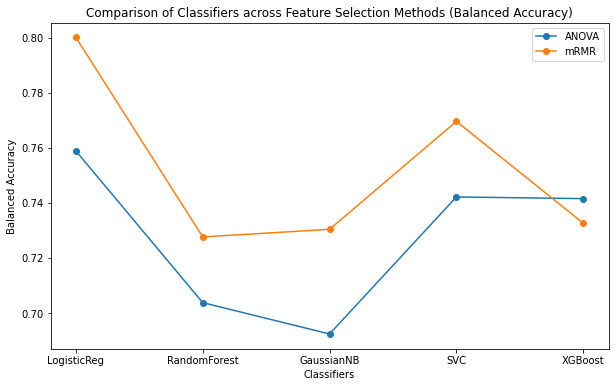

balanced_acc_LG 0.7588067811512786
balanced_acc_RF 0.703756568158482
balanced_acc_GNB 0.6923907656443542
balanced_acc_SVC 0.7421364677824008
balanced_acc_XG 0.7415178128575257
balanced_acc_mrmr_LG 0.8000264811269595
balanced_acc_mrmr_RF 0.7276185292931704
balanced_acc_mrmr_GNB 0.7303797339682506
balanced_acc_mrmr_SVC 0.7695706848816897
balanced_acc_mrmr_XG 0.7326108204098635


In [ ]:
anova_scores = [balanced_acc_LG, balanced_acc_RF, balanced_acc_GNB, balanced_acc_SVC, balanced_acc_XG]
mrmr_scores = [balanced_acc_mrmr_LG, balanced_acc_mrmr_RF, balanced_acc_mrmr_GNB, balanced_acc_mrmr_SVC, balanced_acc_mrmr_XG]
plot_results(anova_scores, mrmr_scores, 'Balanced Accuracy')
for anova_score in anova_scores:
    print(print_variable_name(anova_score), anova_score)

for mrmr_score in mrmr_scores:
    print(print_variable_name(mrmr_score), mrmr_score)

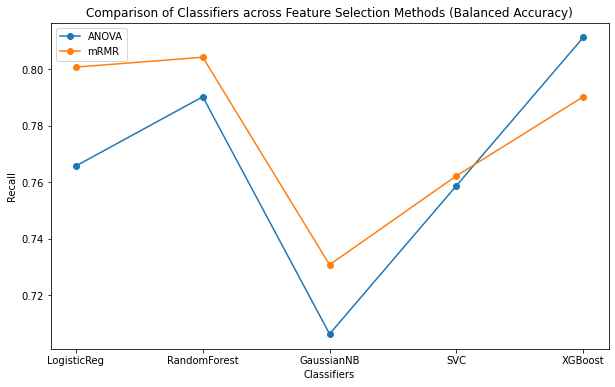

recall_LG 0.7657342657342657
recall_RF 0.7902097902097902
recall_GNB 0.7062937062937062
recall_SVC 0.7587412587412588
recall_XG 0.8111888111888111
recall_mrmr_LG 0.8006993006993007
recall_mrmr_RF 0.8041958041958042
recall_mrmr_GNB 0.7307692307692307
recall_mrmr_SVC 0.7622377622377622
recall_mrmr_XG 0.7902097902097902


In [ ]:
anova_scores = [recall_LG, recall_RF, recall_GNB, recall_SVC, recall_XG]
mrmr_scores = [recall_mrmr_LG, recall_mrmr_RF, recall_mrmr_GNB, recall_mrmr_SVC, recall_mrmr_XG]
plot_results(anova_scores, mrmr_scores, "Recall")

for anova_score in anova_scores:
    print(print_variable_name(anova_score), anova_score)

for mrmr_score in mrmr_scores:
    print(print_variable_name(mrmr_score), mrmr_score)

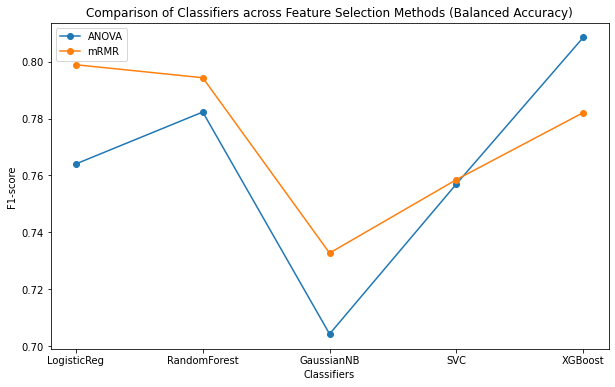

f1_LG 0.7640580849351472
f1_RF 0.7823073747786992
f1_GNB 0.7042189399005377
f1_SVC 0.7569953910318524
f1_XG 0.8085398868940611
f1_mrmr_LG 0.7989390592687791
f1_mrmr_RF 0.794374048574482
f1_mrmr_GNB 0.7326914824295795
f1_mrmr_SVC 0.7585192546861519
f1_mrmr_XG 0.782093679706861


In [ ]:
anova_scores = [f1_LG, f1_RF, f1_GNB, f1_SVC, f1_XG]
mrmr_scores = [f1_mrmr_LG, f1_mrmr_RF, f1_mrmr_GNB, f1_mrmr_SVC, f1_mrmr_XG]
plot_results(anova_scores, mrmr_scores, "F1-score")

for anova_score in anova_scores:
    print(print_variable_name(anova_score), anova_score)

for mrmr_score in mrmr_scores:
    print(print_variable_name(mrmr_score), mrmr_score)

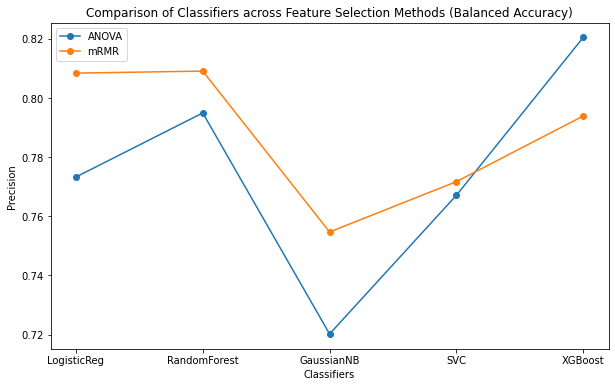

precision_LG 0.773282877273098
precision_RF 0.7949420853901769
precision_GNB 0.7202010788989847
precision_SVC 0.767091877238814
precision_XG 0.8204635998462863
precision_mrmr_LG 0.8084145041477803
precision_mrmr_RF 0.809086547200971
precision_mrmr_GNB 0.7546930570313392
precision_mrmr_SVC 0.7717127402286617
precision_mrmr_XG 0.7939109711836984


In [ ]:
anova_scores = [precision_LG, precision_RF, precision_GNB, precision_SVC, precision_XG]
mrmr_scores = [precision_mrmr_LG, precision_mrmr_RF, precision_mrmr_GNB, precision_mrmr_SVC, precision_mrmr_XG]
plot_results(anova_scores, mrmr_scores, "Precision")

for anova_score in anova_scores:
    print(print_variable_name(anova_score), anova_score)

for mrmr_score in mrmr_scores:
    print(print_variable_name(mrmr_score), mrmr_score)